In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score

In [87]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('trained_preprocessed.csv')
df

,sleep_hours,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,6.400000,2015,2,19,0,0,0,0,1,0,0
1,7.583333,2015,2,20,1,0,0,0,0,0,0
2,6.350000,2015,2,21,0,0,1,0,0,0,0
3,6.500000,2015,2,22,0,0,0,1,0,0,0
4,8.916667,2015,2,23,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2349,7.933333,2021,12,25,0,0,1,0,0,0,0
2350,3.850000,2021,12,26,0,0,0,1,0,0,0
2351,6.175000,2021,12,29,0,0,0,0,0,0,1
2352,5.158333,2021,12,30,0,0,0,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sleep_hours    2354 non-null   float64
 1   year           2354 non-null   int64  
 2   month          2354 non-null   int64  
 3   day            2354 non-null   int64  
 4   dow_Friday     2354 non-null   int64  
 5   dow_Monday     2354 non-null   int64  
 6   dow_Saturday   2354 non-null   int64  
 7   dow_Sunday     2354 non-null   int64  
 8   dow_Thursday   2354 non-null   int64  
 9   dow_Tuesday    2354 non-null   int64  
 10  dow_Wednesday  2354 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 202.4 KB


In [34]:
test = pd.read_csv('test_preprocessed.csv')

In [35]:
test

,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,2022,1,1,0,0,1,0,0,0,0
1,2022,1,2,0,0,0,1,0,0,0
2,2022,1,3,0,1,0,0,0,0,0
3,2022,1,4,0,0,0,0,0,1,0
4,2022,1,5,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
414,2023,3,12,0,0,0,1,0,0,0
415,2023,3,13,0,1,0,0,0,0,0
416,2023,3,14,0,0,0,0,0,1,0
417,2023,3,15,0,0,0,0,0,0,1


## Outlier Cleaning
### 1) Using IQR method

In [5]:
# Calculate the IQR
Q1 = df['sleep_hours'].quantile(0.25)
Q3 = df['sleep_hours'].quantile(0.75)
IQR = Q3 - Q1

In [6]:
# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [7]:
# Remove outliers
df2 = df[(df['sleep_hours'] >= lower_bound) & (df['sleep_hours'] <= upper_bound)].copy()

In [8]:
df.shape

(2354, 11)

In [9]:
df2.shape

(2057, 11)

<AxesSubplot:>

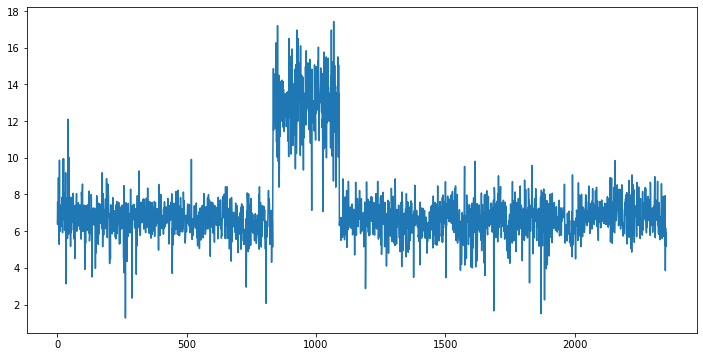

In [10]:
df['sleep_hours'].plot(figsize=(12,6))

<AxesSubplot:>

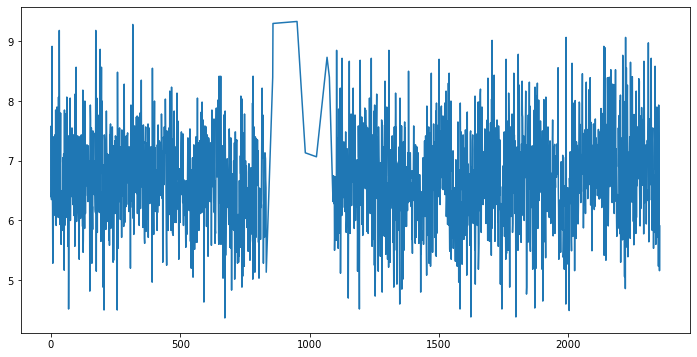

In [11]:
df2['sleep_hours'].plot(figsize=(12,6))

In [49]:
df.groupby('year').mean()['sleep_hours']

year
2015    6.790343
2016    6.688550
2017    8.210859
2018    9.624811
2019    6.512500
2020    6.594832
2021    6.904003
Name: sleep_hours, dtype: float64

In [50]:
df2.groupby('year').mean()['sleep_hours']

year
2015    6.777042
2016    6.738983
2017    6.592283
2018    6.781347
2019    6.568008
2020    6.681028
2021    6.904308
Name: sleep_hours, dtype: float64

In [14]:
df['sleep_hours'].describe()

count    2354.000000
mean        7.356560
std         2.213308
min         1.266667
25%         6.235417
50%         6.816667
75%         7.483333
max        17.433333
Name: sleep_hours, dtype: float64

In [15]:
df2['sleep_hours'].describe()

count    2057.000000
mean        6.718153
std         0.796329
min         4.366667
25%         6.216667
50%         6.700000
75%         7.233333
max         9.333333
Name: sleep_hours, dtype: float64

<AxesSubplot:>

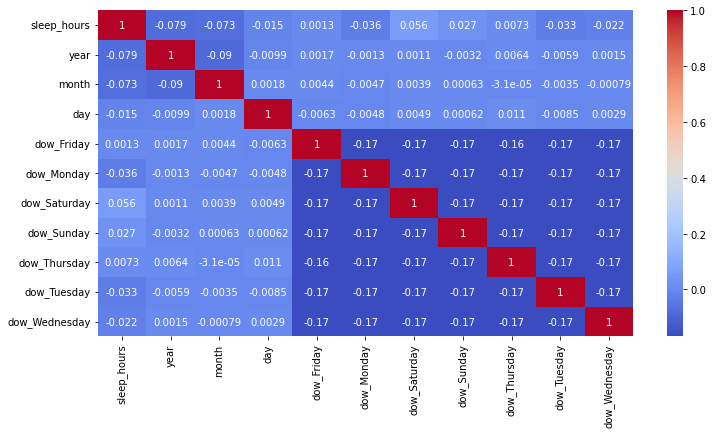

In [43]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

<AxesSubplot:>

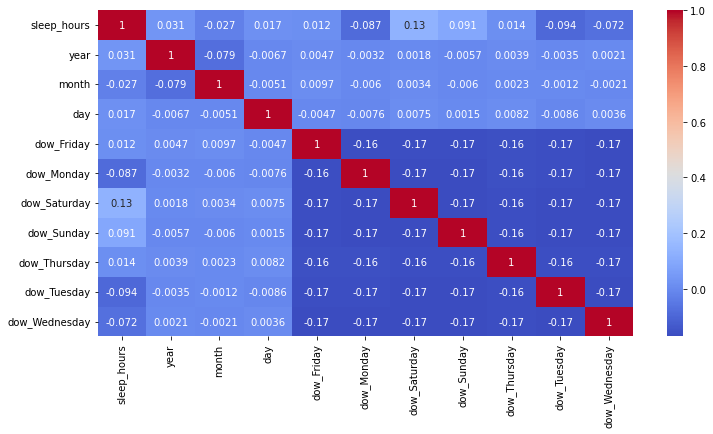

In [42]:
plt.figure(figsize=(12,6))
sns.heatmap(df2.corr(),annot=True,cmap='coolwarm')

### 2) Using Gaussian method

In [13]:
df['sleep_hours'].describe()

count    2354.000000
mean        7.356560
std         2.213308
min         1.266667
25%         6.235417
50%         6.816667
75%         7.483333
max        17.433333
Name: sleep_hours, dtype: float64

In [100]:
df3 = df[(df['sleep_hours'] <= df['sleep_hours'].mean() + 1*df['sleep_hours'].std()) & (df['sleep_hours'] >= df['sleep_hours'].mean() - 1*df['sleep_hours'].std()) ]

In [101]:
df3

,sleep_hours,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,6.400000,2015,2,19,0,0,0,0,1,0,0
1,7.583333,2015,2,20,1,0,0,0,0,0,0
2,6.350000,2015,2,21,0,0,1,0,0,0,0
3,6.500000,2015,2,22,0,0,0,1,0,0,0
4,8.916667,2015,2,23,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2348,5.233333,2021,12,24,1,0,0,0,0,0,0
2349,7.933333,2021,12,25,0,0,1,0,0,0,0
2351,6.175000,2021,12,29,0,0,0,0,0,0,1
2352,5.158333,2021,12,30,0,0,0,0,1,0,0


In [102]:
print(df2.shape)
print(df3.shape)

(2057, 11)
(2011, 11)


In [73]:
df.groupby('year').mean()['sleep_hours']

year
2015    6.790343
2016    6.688550
2017    8.210859
2018    9.624811
2019    6.512500
2020    6.594832
2021    6.904003
Name: sleep_hours, dtype: float64

In [74]:
df3.groupby('year').mean()['sleep_hours']

year
2015    6.765415
2016    6.715738
2017    6.905931
2018    7.271818
2019    6.512500
2020    6.635352
2021    6.904003
Name: sleep_hours, dtype: float64

In [75]:
df['sleep_hours'].describe()

count    2354.000000
mean        7.356560
std         2.213308
min         1.266667
25%         6.235417
50%         6.816667
75%         7.483333
max        17.433333
Name: sleep_hours, dtype: float64

In [76]:
df3['sleep_hours'].describe()

count    2144.000000
mean        6.786486
std         1.081741
min         2.950000
25%         6.200000
50%         6.716667
75%         7.275000
max        11.733333
Name: sleep_hours, dtype: float64

<AxesSubplot:>

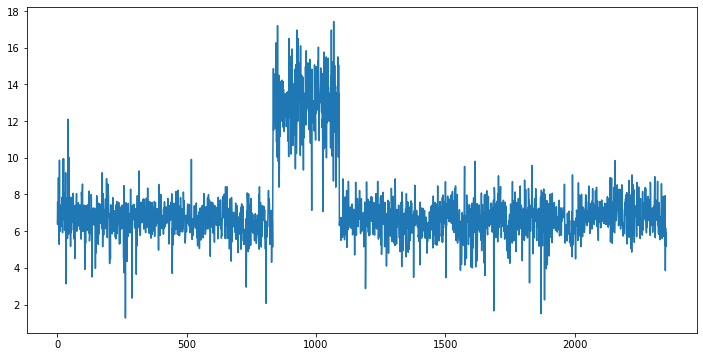

In [52]:
df['sleep_hours'].plot(figsize=(12,6))

<AxesSubplot:>

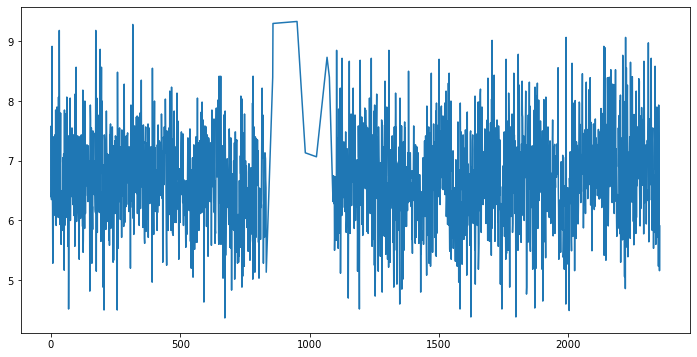

In [53]:
df2['sleep_hours'].plot(figsize=(12,6))

In [26]:
X = df2.drop('sleep_hours',axis=1)
y = df2['sleep_hours']

### Let's use AutoMl on df2 and df3

In [88]:
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "verbose":False
}

In [89]:
automl.fit(X,y, **automl_settings)

In [90]:
automl.best_estimator

'lgbm'

In [91]:
automl.best_loss

0.7778956214992633

In [92]:
#sub = pd.read_csv('sample_submission.csv')

In [93]:
#sub['sleep_hours'] = automl.predict(test)

In [94]:
#sub.to_csv('automl_5.csv',index=False)

<AxesSubplot:>

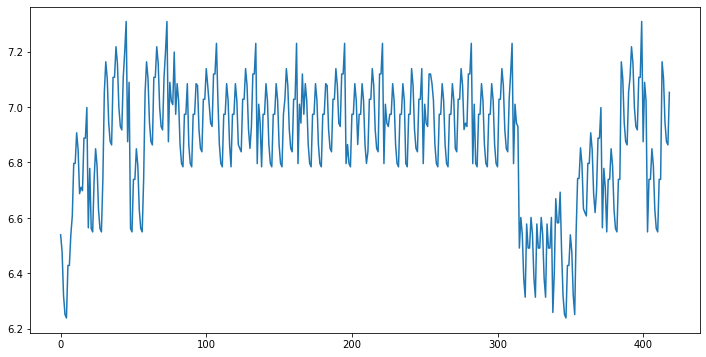

In [95]:
pd.Series(automl.predict(test)).plot(figsize=(12,6))

<AxesSubplot:xlabel='date'>

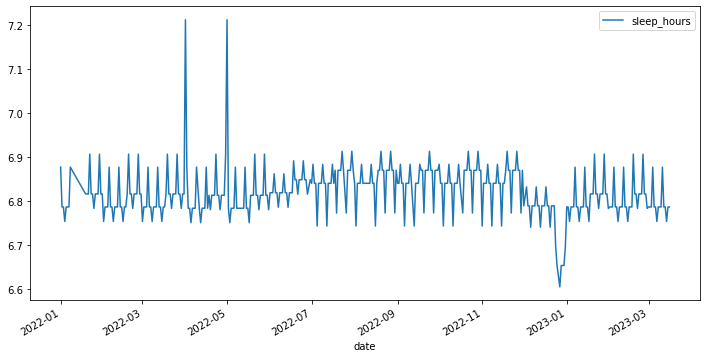

In [67]:
pd.read_csv('automl_1-rank-6.csv', parse_dates=['date'],index_col='date').plot(figsize=(12,6))

In [66]:
pd.read_csv('automl_1-rank-6.csv', parse_dates=['date'],index_col='date').describe()

,sleep_hours
count,419.000000
mean,6.821418
std,0.055228
min,6.605007
25%,6.786734
50%,6.816316
75%,6.866204
max,7.212479


In [63]:
sub['sleep_hours'].describe()

count    419.000000
mean       6.877532
std        0.218481
min        6.239414
25%        6.784294
50%        6.918902
75%        7.027945
max        7.308282
Name: sleep_hours, dtype: float64

In [68]:
df3

,sleep_hours,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,6.400000,2015,2,19,0,0,0,0,1,0,0
1,7.583333,2015,2,20,1,0,0,0,0,0,0
2,6.350000,2015,2,21,0,0,1,0,0,0,0
3,6.500000,2015,2,22,0,0,0,1,0,0,0
4,8.916667,2015,2,23,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2349,7.933333,2021,12,25,0,0,1,0,0,0,0
2350,3.850000,2021,12,26,0,0,0,1,0,0,0
2351,6.175000,2021,12,29,0,0,0,0,0,0,1
2352,5.158333,2021,12,30,0,0,0,0,1,0,0


## Implementation on df3

In [77]:
X2 = df3.drop('sleep_hours',axis=1)
y2 = df3['sleep_hours']

In [79]:
automl2 = AutoML()
automl_settings2 = {
    "time_budget": 30,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "verbose":False
}

## We can also try encoding the day of the week column into numerical depending on the correlation

In [57]:
df.corr()['sleep_hours'].sort_values(ascending=False)[1:]

dow_Saturday     0.055854
dow_Sunday       0.026556
dow_Thursday     0.007301
dow_Friday       0.001257
day             -0.014685
dow_Wednesday   -0.022398
dow_Tuesday     -0.032569
dow_Monday      -0.035885
month           -0.073311
year            -0.078989
Name: sleep_hours, dtype: float64

### Monday: 1 ; Tuesday: 2 ; Wednesday: 3 ; Thursday: 4 ; Friday: 5 ; Sunday: 6; Saturday: 7